# Intelligent Systems - Individual Project Assessment
I aim to split the code into 3 sections:
1. Generating and analysing the datset
2. Developing my classification model
3. Training my model

In [77]:
import math
import time

import matplotlib.pyplot as plt
import torch
from jinja2 import optimizer
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import scipy.io as sio
import numpy as np
from torchvision.transforms import Lambda

In [78]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datase

In [79]:
# We perform random transformations to better generalise the training dataset
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    # I have chosen not to use RandomResizeCrop as it can remove large parts of the flowers
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])
valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

### Downloading and splitting the dataset

In [80]:
# I will download the data from PyTorch's website and use the appropriate data loader
train_dataset = datasets.Flowers102(
    root='flowers102',
    split="train",
    download=True,
    transform=train_transform,
    target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

valid_dataset = datasets.Flowers102(
    root='flowers102',
    split="val",
    download=True,
    transform=valid_transform,
    target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = datasets.Flowers102(
    root='flowers102',
    split="test",
    download=True,
    transform=test_transform,
    target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# Get the targets and ids
image_labels = sio.loadmat("flowers102/flowers-102/imagelabels")
setids = sio.loadmat("flowers102/flowers-102/setid")
print(np.unique(image_labels['labels']).size)
train_ids = setids['trnid']

102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: <built-in method type of Tensor object at 0x000001EB8CF396D0>
Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Device tensor is stored on: cpu


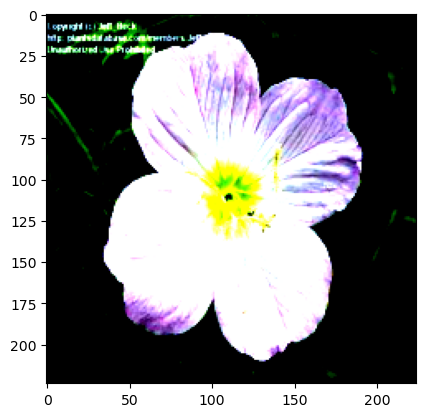

In [81]:
# look at the first training sample
image, label = train_dataset[1]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.type}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.permute(1, 2, 0))

## Model
I am first going to implement a very basic Convolutional Neural Network as these work well with images

In [82]:
# Making my Convolutional Neural Network
class MyNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Feature Learning ###
        # 3 Input channels
        self.conv1 = nn.Conv2d(3, out_channels=32, kernel_size=9, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # ### Classification ###
        self.flatten = nn.Flatten()
        
        # After the 3rd convolutional layer, the filters will have dimensions 26x26
        # 128 x 28 x 28 features
        self.fc1 = nn.Linear(128*28*28, 512)
        # Classify into one of the flower categories
        self.fc2 = nn.Linear(512, 102)
        
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Flatten the tensor for fully connected layers        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = self.softmax(x)        
        return x

In [83]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))

In [84]:
net = MyNN().to(device)

### Loss Function

In [85]:
criterion = nn.CrossEntropyLoss()

### Optimiser

In [86]:
# Momentum pushes the optimiser towards the strongest gradient over multiple steps.
optimiser = optim.SGD(net.parameters(), lr=0.001)

## Training

In [90]:
def epoch_train(model, dataloader):
    model.train()
    model.train()
    losses = list()
    for idx, data in enumerate(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
            
        optimiser.zero_grad()
        
        out = model(inputs)
        print(out[0])
        loss = criterion(out.squeeze(), labels)
        
        loss.backward()
        optimiser.step()
        losses.append(loss.item())
        
        if idx % 10 == 9:
            print(f"Batch {idx+1}, Loss: {loss}")
        
    return np.mean(losses), model

In [88]:
def train(model, train_loader, epochs):
    start_time = time.time()
    print("[INFO] Training starting...")
    losses = []
    
    for epoch in range(epochs):
        train_loss, model = epoch_train(model, train_loader)
        losses.append(train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}")

    finish_time = time.time()
    print("[INFO] Training Finished")
    print(f"Elapsed time: {math.floor((finish_time-start_time)/60)}:{math.floor((finish_time-start_time)%60)}")
    PATH = 'model.pth'
    torch.save(net.state_dict(), PATH)
    return losses

In [91]:
epochs = 50
losses = train(net, train_loader, epochs)

[INFO] Training starting...
tensor([0.0097, 0.0101, 0.0099, 0.0094, 0.0101, 0.0087, 0.0103, 0.0096, 0.0094,
        0.0103, 0.0097, 0.0098, 0.0095, 0.0100, 0.0096, 0.0097, 0.0099, 0.0106,
        0.0096, 0.0100, 0.0098, 0.0098, 0.0109, 0.0105, 0.0097, 0.0097, 0.0101,
        0.0096, 0.0098, 0.0099, 0.0096, 0.0097, 0.0092, 0.0094, 0.0098, 0.0102,
        0.0100, 0.0097, 0.0099, 0.0094, 0.0097, 0.0103, 0.0094, 0.0091, 0.0100,
        0.0103, 0.0100, 0.0098, 0.0099, 0.0098, 0.0100, 0.0091, 0.0098, 0.0100,
        0.0103, 0.0096, 0.0096, 0.0103, 0.0095, 0.0095, 0.0097, 0.0100, 0.0101,
        0.0096, 0.0090, 0.0101, 0.0093, 0.0100, 0.0099, 0.0102, 0.0096, 0.0104,
        0.0097, 0.0092, 0.0097, 0.0095, 0.0098, 0.0099, 0.0097, 0.0094, 0.0093,
        0.0101, 0.0099, 0.0097, 0.0099, 0.0101, 0.0099, 0.0097, 0.0099, 0.0100,
        0.0095, 0.0095, 0.0097, 0.0105, 0.0097, 0.0100, 0.0095, 0.0095, 0.0102,
        0.0100, 0.0102, 0.0099], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0099,

KeyboardInterrupt: 

In [ ]:
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))

In [ ]:
def evaluate(model, valid_loader):
    model.eval()        
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(valid_loader):
            X = data[0].to(device)
            y = data[1].to(device)
            
            predicted = model(X)
            acc+=(predicted.round() == y).sum()/float(predicted.shape[0])       
    model.train()
    return (acc/(i+1)).detach().item()

In [ ]:
valid_accuracy = evaluate(net, valid_loader)
print(f"Model's Validation Accuracy: {valid_accuracy*100}")